In [5]:
import os
import cv2
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [2]:
import sys
import tensorflow.keras
from tensorflow.python.client import device_lib

print(sys.version)
print('-'*50)
!python --version
print('-'*50)
print('tensorflow:{}'.format(tensorflow.keras.__version__))
print('-'*50)
print("Num GPUs Available:",len(tf.config.experimental.list_physical_devices('GPU')))
for i in tf.config.list_physical_devices('GPU'):
    print(i)   
for i in device_lib.list_local_devices()[-len(tf.config.experimental.list_physical_devices('GPU')):]:
    print('-'*50)
    print(i)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
--------------------------------------------------
Python 3.6.10 :: Anaconda, Inc.
--------------------------------------------------
tensorflow:2.6.0
--------------------------------------------------
Num GPUs Available: 0
--------------------------------------------------
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5716015972855457776



# 데이터 확인

In [4]:
%%time
df = pd.read_csv('./data/clustering2.csv', encoding='utf-8', index_col=0)

CPU times: user 24.5 s, sys: 1.35 s, total: 25.9 s
Wall time: 25.8 s


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51260 entries, 0 to 51259
Columns: 2051 entries, filename to center_distance
dtypes: float64(2049), int64(1), object(1)
memory usage: 802.5+ MB


In [7]:
df.columns

Index(['filename', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047',
       'cluster', 'center_distance'],
      dtype='object', length=2051)

In [8]:
df['cluster'].value_counts()

3    12155
2    11752
4     9528
0     9489
1     8336
Name: cluster, dtype: int64

- 시각화를 위한 샘플링 1000개

In [9]:
from sklearn.model_selection import train_test_split

X = []
y = []

path = './data/2_15_crop'

for i in range(5):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 1000, replace=False)
    for file in tqdm_notebook(random_set):
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        X.append(dst)
        y.append(df[df['filename'] == file]['cluster'].values[0]) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
len(X), len(y)

(5000, 5000)

In [19]:
%%time

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

X_train, X_test = X_train/255.0, X_test/225.0 # 모델 적용을 위한 정규화

CPU times: user 3.32 s, sys: 6.59 s, total: 9.91 s
Wall time: 9.9 s


In [20]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

4000 1000
4000 1000


# 저장된 모델 불러와서 실제 5개 클러스터 데이터에 적용

In [21]:
load_model = load_model('./InceptionV3.h5')

## 1. test 데이터에 그대로 적용(실제로 validation data)

In [22]:
len(X_train), len(y_train)

(4000, 4000)

In [23]:
len(X_test), len(y_test)

(1000, 1000)

In [24]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
%%time
# load된 모델을 평가
loss, acc = load_model.evaluate(X_test,  y_test, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))
print('복원된 모델의 Loss: {:5.2f}%'.format(100*loss))

32/32 - 21s - loss: 0.2722 - accuracy: 0.8900
복원된 모델의 정확도: 89.00%
복원된 모델의 Loss: 27.22%
CPU times: user 6min 10s, sys: 25.2 s, total: 6min 35s
Wall time: 22.6 s


In [26]:
%%time
y_predict = load_model.predict(X_test)

CPU times: user 6min 12s, sys: 22 s, total: 6min 34s
Wall time: 22.2 s


In [27]:
print(y_predict.shape)

(1000, 5)


In [28]:
y_predict[:5]

array([[1.31416109e-05, 4.38917577e-01, 1.90164568e-03, 1.35812564e-02,
        5.45586407e-01],
       [5.96802374e-06, 1.75020864e-06, 2.86460835e-02, 9.68183696e-01,
        3.16256611e-03],
       [2.67228752e-01, 1.05437481e-08, 7.31456757e-01, 2.33061117e-04,
        1.08141836e-03],
       [3.91120644e-04, 2.12647521e-12, 9.99274671e-01, 1.47501268e-07,
        3.34161858e-04],
       [6.04415014e-02, 1.65228954e-07, 9.31180775e-01, 1.45057575e-05,
        8.36306997e-03]], dtype=float32)

In [29]:
y_pred = []

for i in y_predict:
    i = list(i)
    tmp = max(i)
    index = i.index(tmp)
    y_pred.append(index)

y_pred[:5]

[4, 3, 2, 2, 2]

In [41]:
y_test[:5]

array([1, 3, 0, 2, 2])

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[157,   0,  29,   5,   9],
       [  0, 193,   0,   6,   1],
       [  3,   0, 185,   3,   9],
       [  3,   8,   1, 188,   0],
       [  1,   3,  24,   5, 167]])

## 2. 다시 샘플링하여 새로운 데이터 적용(replace = False)

In [32]:
from sklearn.model_selection import train_test_split

XX = []
yy = []

path = './data/2_15_crop'

for i in tqdm_notebook(range(5)):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 200, replace=False)
    for file in random_set:
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        XX.append(dst)
        yy.append(df[df['filename'] == file]['cluster'].values[0]) 

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
XX = np.array(XX)
yy = np.array(yy)

XX = XX/255.0 # 정규화!

In [34]:
len(XX), len(yy)

(1000, 1000)

In [35]:
%%time
# load된 모델을 평가
loss, acc = load_model.evaluate(XX,  yy, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))
print('복원된 모델의 Loss: {:5.2f}%'.format(100*loss))

32/32 - 19s - loss: 0.2569 - accuracy: 0.8850
복원된 모델의 정확도: 88.50%
복원된 모델의 Loss: 25.69%
CPU times: user 6min 8s, sys: 24.7 s, total: 6min 33s
Wall time: 20.9 s


In [36]:
%%time
y_predict = load_model.predict(XX)

CPU times: user 6min 11s, sys: 23.2 s, total: 6min 34s
Wall time: 21 s


In [37]:
print(y_predict.shape)

(1000, 5)


In [38]:
y_pred = []

for i in y_predict:
    i = list(i)
    tmp = max(i)
    index = i.index(tmp)
    y_pred.append(index)

y_pred[:5]

[2, 3, 0, 0, 0]

In [39]:
confusion_matrix(yy, y_pred)

array([[150,   1,  34,   7,   8],
       [  0, 192,   0,   5,   3],
       [  1,   0, 192,   3,   4],
       [  0,  15,   2, 182,   1],
       [  5,   3,  21,   2, 169]])

In [40]:
y_predict

array([[3.6097786e-01, 3.2644920e-08, 5.9426910e-01, 1.8637540e-04,
        4.4566642e-02],
       [2.0154738e-01, 5.2300220e-10, 4.3378291e-03, 7.9411256e-01,
        2.2363124e-06],
       [5.4957032e-01, 1.1810687e-10, 4.5038736e-01, 9.6512838e-07,
        4.1329618e-05],
       ...,
       [4.7299541e-03, 1.9569157e-02, 5.9639284e-04, 2.3927428e-02,
        9.5117712e-01],
       [1.2706533e-06, 6.3679474e-03, 1.5867347e-04, 1.2962989e-05,
        9.9345917e-01],
       [2.2383046e-04, 5.9682671e-02, 2.2119966e-03, 2.1519982e-04,
        9.3766624e-01]], dtype=float32)

## 최적화 이후 유사도

In [42]:
from tensorflow.keras.models import Model

get_vector = Model(inputs=load_model.input, outputs=load_model.get_layer('global_average_pooling2d').output)

In [43]:
# load data
features = []

path = './data/2_15_crop'

for image in tqdm_notebook(os.listdir(path)):
    file_path = path + '/' + image
    src = cv2.imread(file_path, cv2.IMREAD_COLOR)
    dst = cv2.resize(src, dsize=(299,299), interpolation=cv2.INTER_CUBIC)
    img_data = np.expand_dims(dst, axis=0)
    img_data = preprocess_input(img_data)
    features.append(load_model.predict(img_data)[0])

  0%|          | 0/51260 [00:00<?, ?it/s]

KeyError: '32465.jpg'

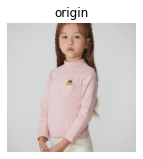

In [35]:
# random sampleing
random_samples = np.random.choice(os.listdir(path), 10)
random_samples

for filename in random_samples:
    show_sim_image(filename)
    print('\n')

KeyError: '32465.jpg'

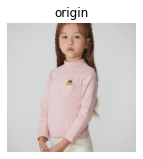

In [35]:
# random sampleing
random_samples = np.random.choice(os.listdir(path), 10)
random_samples

for filename in random_samples:
    show_sim_image(filename)
    print('\n')